In [310]:
import platform

global systemDivide
if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

import sys
import threading

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

In [311]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)

# initParameters = {
#     'yThreshold': 300,
#     'rollingMean': 500,
#     'fatRollingMean': 2500,
#     'timeBarrier': 1100,
#     'varianceRatioFilter': 1.1,
#     'restAfterLoss': 350,
#     'restAfterFatProfit' : 50,
#     'stopLossPercent': 1,
#     'takeProfitPercent': 10,
#     'varianceRatioCarreteParameter': 20,
#     }
initParameters = {
    'yThreshold': 240,
    'rollingMean': 600,
    'fatRollingMean': 1800,
    'timeBarrier': 800,
    'varianceRatioFilter': 1.0,
    'restAfterLoss': 150,
    'restAfterFatProfit' : 50,
    'stopLossPercent': .25,
    'takeProfitPercent': 10,
    'varianceRatioCarreteParameter': 10,
    }

# Проверим распределение доходностей на нормальность

3 sigma anomalies 1.275%


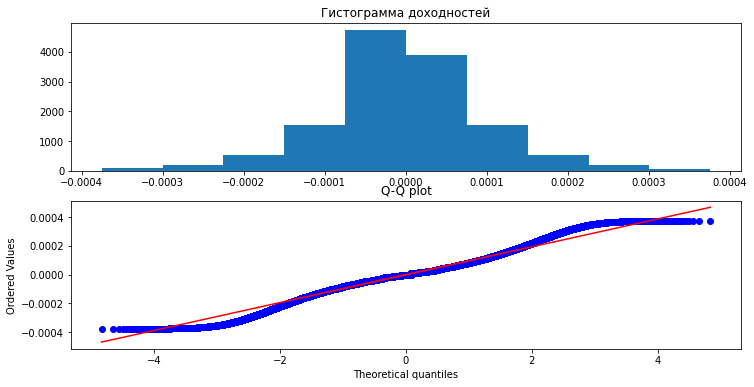

In [312]:
import matplotlib.pylab as plt
from scipy.stats import zscore, probplot

plt.style.use(style='fast')
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('Гистограмма доходностей')
abs_Z_scores = np.abs(zscore(inpData.open.pct_change().iloc[1:]))
filtered = (abs_Z_scores < 3)
print(f'3 sigma anomalies {(1 - sum(filtered) / inpData.shape[0]):.3%}')
bars = plt.hist(inpData.open.pct_change().values[1:][filtered], density=True, )
ax = plt.subplot(2,1,2)

probplot(inpData.open.pct_change().values[1:][filtered], plot=ax)
plt.title(f'Q-Q plot')
plt.show()
del abs_Z_scores, filtered, bars

In [313]:
def create_grid(params: initParameters):
    """
    Создает удобную сетку для дальнейших расчетов
    :param params: начальные init параметры
    :return: словарь из параметров использующийся везде
    """
    capital = 20_000
    slippage = 2
    retParams = {
        'capital': capital,
        'slippagePerCapital': slippage / capital,
        'yThreshold': round(params['yThreshold'] / 100, 2),
        'rollingMean': params['rollingMean'],
        'fatRollingMean': params['fatRollingMean'],
        'timeBarrier': params['timeBarrier'],
        'varianceRatioFilter': params['varianceRatioFilter'],
        'restAfterLoss': params['restAfterLoss'],
        'restAfterFatProfit' : params['restAfterFatProfit'],
        'stopLossThreshold': round(params['stopLossPercent'] / 100, 3),
        'takeProfitThreshold': round(params['takeProfitPercent'] / 100, 3),
        'varianceLookBack': params['rollingMean'] * 2,
        'varianceRatioCarrete': int((params['rollingMean'] * 2) // params['varianceRatioCarreteParameter']) + 1,
    }
    return retParams

def cook_data(df: pd.DataFrame, params) -> pd.DataFrame:
    """
    Подготавливает данные для дальнейшего рассчета стратегии.
    :param df: должен быть open, close, low, high
    :param params: список параметров из create_grid
    :return: данные с полосами Болинджера + логарифмы + возвраты
    """
    df['rollMean'] = df['open'].rolling(window=params['rollingMean']).mean()
    df['rollingStd'] = df['open'].rolling(window=params['rollingMean']).std()
    df['HBBand'] = df['rollMean'] + df['rollingStd'] * params['yThreshold']
    df['LBBand'] = df['rollMean'] - df['rollingStd'] * params['yThreshold']
    df['fatMean'] = df['open'].rolling(window=params['fatRollingMean']).mean()
    df['logOpenPrice'] = np.log(df['open'])
    df['retOpenPrice'] = df['logOpenPrice'].diff()
    return df.iloc[max(params['varianceLookBack'], params['fatRollingMean']):]

def variance_ratio(logTuple: tuple, retTuple: tuple, params: dict) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = params['varianceRatioCarrete'] * (buffer_size - params['varianceRatioCarrete'] + 1 ) * (1 - (params['varianceRatioCarrete'] / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, params['varianceRatioCarrete']))[params['varianceRatioCarrete']:]
    _buff_ = np.sum(np.square(subtract_returns - params['varianceRatioCarrete'] * means))

    sigma_b = (1 / m) * _buff_
    result = (sigma_b / sigma_a)
    if result < params['varianceRatioFilter']:
        return True
    else:
        return False

def reverse_variance_ratio(logTuple: tuple, retTuple: tuple, params: dict, timeBorderCounter: int) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    if timeBorderCounter < params["varianceLookBack"]:
        buffer_size = len(retTuple)
        means = (1 / buffer_size) * np.sum(retTuple)
        # сдвиг во времени q
        m = timeBorderCounter * (buffer_size - timeBorderCounter + 1 ) * (1 - (timeBorderCounter / buffer_size))
        sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
        subtract_returns = np.subtract(logTuple, np.roll(logTuple, timeBorderCounter))[timeBorderCounter:]
        _buff_ = np.sum(np.square(subtract_returns - timeBorderCounter * means))
        sigma_b = (1 / m) * _buff_
        result = (sigma_b / sigma_a)
        if result > params['varianceRatioFilter']:
            return True
        else:
            return False
    else:
        return False


def open_position(arrowIndex, recursionFilter, LBandTuple, HBandTuple, LowTuple,
                 HighTuple, OpenTuple, params, logTuple, retTuple) -> dict:
    """
    Возвращает список с типом сделанной сделки
    :param arrowIndex: Навигация по полному массиву данных
    :param recursionFilter: ограничитель ошибок связанных с забитием памяти и превышением лимита рекурсии
    :param LBandTuple: нижняя граница болинджера
    :param HBandTuple: верхняя полоса болинджера
    :param LowTuple: low цена
    :param HighTuple: high цена
    :param OpenTuple: open цена
    :param params: список параметров полученных с помощью create_grid
    :param logTuple: необходим для расчета Variance ratio
    :param retTuple: необходим для расчета Variance ratio
    :return: список о сделанной сделке
    """
    LOGIC_BOOL = False
    _recursion_limit = 10_000

    openDict = {
        'typeOperation': None,
        'position': None,
        'openPrice': None,
        'openIndex': None,
        'stopLossBorder': None,
        'takeProfitBorder': None
    }
    if recursionFilter > _recursion_limit:
        return arrowIndex

        # Текущее открытие должно находится выше нижней полосы Болинджера,
        # тогда в случае если LOW пересекает полосу покупаем контракт по цене LBBand
    if (OpenTuple[arrowIndex] > LBandTuple[arrowIndex]) and (LowTuple[arrowIndex] < LBandTuple[arrowIndex]):
        if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
            openDict['typeOperation'] = 'BUY'
            openDict['position'] = params['capital'] / LBandTuple[arrowIndex]
            openDict['openPrice'] = LBandTuple[arrowIndex]
            openDict['openIndex'] = arrowIndex
            openDict['stopLossBorder'] = LBandTuple[arrowIndex] * (1 - params['stopLossThreshold'])
            openDict['takeProfitBorder'] = LBandTuple[arrowIndex] * (1 + params['takeProfitThreshold'])
            LOGIC_BOOL = True
            return openDict

    elif (OpenTuple[arrowIndex] < HBandTuple[arrowIndex]) and (HighTuple[arrowIndex] > HBandTuple[arrowIndex]):
        if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
            openDict['typeOperation'] = 'SELL'
            openDict['position'] = -1 * (params['capital'] / HBandTuple[arrowIndex])
            openDict['openPrice'] = HBandTuple[arrowIndex]
            openDict['openIndex'] = arrowIndex
            openDict['stopLossBorder'] = HBandTuple[arrowIndex] * (1 + params['stopLossThreshold'])
            openDict['takeProfitBorder'] = HBandTuple[arrowIndex] * (1 - params['takeProfitThreshold'])
            LOGIC_BOOL = True
            return openDict

    if not LOGIC_BOOL:
        return open_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1, LBandTuple=LBandTuple,
                     HBandTuple=HBandTuple, LowTuple=LowTuple, HighTuple=HighTuple, OpenTuple=OpenTuple, params=params,
                     logTuple=logTuple, retTuple=retTuple)


def close_position(arrowIndex, recursionFilter, openDict, LowTuple, HighTuple, OpenTuple, LightMeanTuple, FatMeanTuple,
                   params, logTuple, retTuple, timeBorderCounter, indicatorVR) -> dict:
    """

    :param arrowIndex:
    :param recursionFilter:
    :param openDict:
    :param LowTuple:
    :param HighTuple:
    :param OpenTuple:
    :param LightMeanTuple:
    :param FatMeanTuple:
    :param params:
    :param logTuple:
    :param retTuple:
    :param timeBorderCounter:
    :param indicatorVR:
    :return:
    """
    _recursion_limit = 10_000
    NOT_NONE_SAVER = False

    if recursionFilter > _recursion_limit:
        return [arrowIndex, indicatorVR]

    if timeBorderCounter >= params['timeBarrier']:
        return {'typeHolding': 'endPeriod', 'closePrice': OpenTuple[arrowIndex+1],
                        'closeIndex': arrowIndex+1}

    elif openDict['typeOperation'] == 'BUY':
        # Stop Loss
        if LowTuple[arrowIndex] < openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': arrowIndex + params['restAfterLoss']}

        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой
        elif (OpenTuple[arrowIndex] < LightMeanTuple[arrowIndex]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if HighTuple[arrowIndex] > LightMeanTuple[arrowIndex]:
                # Проверяем можно ли продолжить удержание позиции
                if LightMeanTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                    if not reverse_variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      retTuple=retTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      params=params, timeBorderCounter=timeBorderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                                              retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                                              indicatorVR=True)

                    else:
                        # small MA
                        return {'typeHolding': 'lightCross', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex }

                else:
                    # emergent exit
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex + params['restAfterFatProfit']}

        # Ждем пересечение с толстой скользящей
        if indicatorVR:
            if OpenTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                if HighTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': FatMeanTuple[arrowIndex],
                            'closeIndex': arrowIndex}
                if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                    indicatorVR = False
    """================================================================================="""

    if openDict['typeOperation'] == 'SELL':
        # Stop Loss
        if HighTuple[arrowIndex] > openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': arrowIndex + params['restAfterLoss']}

        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой
        elif (OpenTuple[arrowIndex] > LightMeanTuple[arrowIndex]) and (not indicatorVR):
            # Проверяем что можно закрыть шорт о пересечение с малой скользящей
            if LowTuple[arrowIndex] < LightMeanTuple[arrowIndex]:
                # Проверяем можно ли продолжить удержание позиции
                if LightMeanTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                    if not reverse_variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      retTuple=retTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      params=params, timeBorderCounter=timeBorderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                                              retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                                              indicatorVR=True)

                    else:
                        # small MA
                        return {'typeHolding': 'lightCross', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex }

                else:
                    # emergent exit
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex + params['restAfterFatProfit']}

        # Ждем пересечение с толстой скользящей
        if indicatorVR:
            if OpenTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                if LowTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': FatMeanTuple[arrowIndex],
                            'closeIndex': arrowIndex}
                if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                    indicatorVR = False



    if not NOT_NONE_SAVER:
        return close_position(arrowIndex=arrowIndex + 1, recursionFilter=recursionFilter + 1,
                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                              retTuple=retTuple, timeBorderCounter=timeBorderCounter + 1,
                              indicatorVR=indicatorVR)


startParams = create_grid(initParameters)
cookedData = cook_data(df=inpData.copy(), params=startParams)

RESULT = list()
openPOS = open_position(arrowIndex=startParams['varianceLookBack'], recursionFilter=0, LBandTuple=cookedData.LBBand, HBandTuple=cookedData.HBBand,
             LowTuple=cookedData.low, HighTuple=cookedData.high, OpenTuple=cookedData.open , params=startParams,
             logTuple=cookedData.logOpenPrice, retTuple=cookedData.retOpenPrice)

closePos = close_position(arrowIndex=openPOS['openIndex'], recursionFilter=0, openDict=openPOS, LowTuple=cookedData.low,
                          HighTuple=cookedData.high, OpenTuple=cookedData.open, LightMeanTuple=cookedData.rollMean,
                          FatMeanTuple=cookedData.fatMean, params=startParams, logTuple=cookedData.logOpenPrice,
                          retTuple=cookedData.retOpenPrice, timeBorderCounter=0, indicatorVR=False)
RESULT.append({**openPOS, **closePos})
openPOS = startParams['varianceLookBack'] + closePos['closeIndex']
for i in tqdm(range(450)):
    while type(openPOS) is not dict:
            openPOS = open_position(arrowIndex=openPOS, recursionFilter=0, LBandTuple=cookedData.LBBand, HBandTuple=cookedData.HBBand,
             LowTuple=cookedData.low, HighTuple=cookedData.high, OpenTuple=cookedData.open , params=startParams,
             logTuple=cookedData.logOpenPrice, retTuple=cookedData.retOpenPrice)

    closePos = int(openPOS['openIndex'] + 1)
    indicatorVR = False
    while type(closePos) is not dict:
            closePos = close_position(arrowIndex=closePos, recursionFilter=0, openDict=openPOS, LowTuple=cookedData.low,
                              HighTuple=cookedData.high, OpenTuple=cookedData.open, LightMeanTuple=cookedData.rollMean,
                              FatMeanTuple=cookedData.fatMean, params=startParams, logTuple=cookedData.logOpenPrice,
                              retTuple=cookedData.retOpenPrice, timeBorderCounter=0, indicatorVR=indicatorVR)
            if type(closePos) == list:
                indicatorVR = closePos[1]
                closePos = closePos[0]

    total_dict = {**openPOS, **closePos}
    RESULT.append(total_dict)
    openPOS = closePos['closeIndex'] + 1

RESULT = pd.DataFrame(RESULT)

  0%|          | 0/450 [00:00<?, ?it/s]

In [314]:
RESULT[RESULT.typeHolding == 'fatExtraProfit']

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex
2,SELL,-176.222695,113.492760,5744,113.833238,102.143484,fatExtraProfit,113.398048,6131
3,SELL,-176.128507,113.553452,6308,113.894112,102.198107,fatExtraProfit,113.418885,6364
4,BUY,176.520058,113.301572,6437,112.961667,124.631729,fatExtraProfit,113.389747,6560
25,SELL,-175.760427,113.791258,24092,114.132631,102.412132,fatExtraProfit,113.672534,24199
32,BUY,175.930521,113.681241,29422,113.340198,125.049365,fatExtraProfit,113.756188,29687
66,SELL,-179.795041,111.237773,64135,111.571487,100.113996,fatExtraProfit,110.968843,64825
71,BUY,181.630278,110.113799,66876,109.783458,121.125179,fatExtraProfit,110.231580,67187
85,SELL,-181.192962,110.379563,80713,110.710702,99.341607,fatExtraProfit,110.265994,81506
87,BUY,181.608976,110.126715,82058,109.796335,121.139387,fatExtraProfit,110.278227,82146
88,BUY,181.596041,110.134559,82510,109.804156,121.148015,fatExtraProfit,110.213790,83298


In [315]:
RESULT[(RESULT.typeOperation == 'BUY') & (RESULT.typeHolding == 'endPeriod')]

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex
0,BUY,177.624625,112.597000,1848,112.259209,123.856700,endPeriod,112.740,2649
5,BUY,176.715814,113.176062,6737,112.836534,124.493669,endPeriod,113.226,7539
7,BUY,177.468126,112.696294,9292,112.358205,123.965923,endPeriod,112.782,10094
11,BUY,177.398125,112.740763,12320,112.402541,124.014839,endPeriod,112.632,13122
13,BUY,177.724592,112.533667,13992,112.196066,123.787034,endPeriod,112.835,14794
...,...,...,...,...,...,...,...,...,...
428,BUY,182.957693,109.314889,384189,108.986945,120.246378,endPeriod,109.067,384991
429,BUY,183.445846,109.024001,385015,108.696929,119.926401,endPeriod,109.180,385817
447,BUY,182.383426,109.659087,398828,109.330110,120.624996,endPeriod,109.580,399630
448,BUY,182.589829,109.535126,399920,109.206521,120.488639,endPeriod,109.942,400722


In [316]:
(RESULT["position"] * (RESULT["closePrice"] - RESULT["openPrice"]) - 2 if (RESULT["typeOperation"] == 'BUY').bool else abs(RESULT["position"]) * (RESULT["openPrice"] - RESULT["closePrice"]) - 2).cumsum()

0       23.400254
1      -38.599746
2      -23.909278
3       -2.208188
4       11.356465
          ...    
446   -595.718389
447   -612.142583
448   -539.851574
449   -601.851574
450   -562.334803
Length: 451, dtype: float64

In [317]:
copy_df = RESULT.copy()
copy_df['profit'] = (RESULT["position"] * (RESULT["closePrice"] - RESULT["openPrice"]) - 2 if (RESULT["typeOperation"] == 'BUY').bool else abs(RESULT["position"]) * (RESULT["openPrice"] - RESULT["closePrice"]) - 2)
copy_df

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex,profit
0,BUY,177.624625,112.597000,1848,112.259209,123.856700,endPeriod,112.740000,2649,23.400254
1,SELL,-176.597164,113.252102,4053,113.591858,101.926891,stopLoss,113.591858,4716,-62.000000
2,SELL,-176.222695,113.492760,5744,113.833238,102.143484,fatExtraProfit,113.398048,6131,14.690468
3,SELL,-176.128507,113.553452,6308,113.894112,102.198107,fatExtraProfit,113.418885,6364,21.701089
4,BUY,176.520058,113.301572,6437,112.961667,124.631729,fatExtraProfit,113.389747,6560,13.564654
...,...,...,...,...,...,...,...,...,...,...
446,BUY,181.680251,110.083512,398126,109.753261,121.091863,stopLoss,109.753261,398825,-62.000000
447,BUY,182.383426,109.659087,398828,109.330110,120.624996,endPeriod,109.580000,399630,-16.424193
448,BUY,182.589829,109.535126,399920,109.206521,120.488639,endPeriod,109.942000,400722,72.291009
449,SELL,-181.554513,110.159751,401359,110.490231,99.143776,stopLoss,110.490231,401978,-62.000000


In [318]:
copy_df[(copy_df.typeHolding == 'fatExtraProfit') & (copy_df.profit > 0)]

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex,profit
2,SELL,-176.222695,113.492760,5744,113.833238,102.143484,fatExtraProfit,113.398048,6131,14.690468
3,SELL,-176.128507,113.553452,6308,113.894112,102.198107,fatExtraProfit,113.418885,6364,21.701089
4,BUY,176.520058,113.301572,6437,112.961667,124.631729,fatExtraProfit,113.389747,6560,13.564654
25,SELL,-175.760427,113.791258,24092,114.132631,102.412132,fatExtraProfit,113.672534,24199,18.866918
32,BUY,175.930521,113.681241,29422,113.340198,125.049365,fatExtraProfit,113.756188,29687,11.185367
66,SELL,-179.795041,111.237773,64135,111.571487,100.113996,fatExtraProfit,110.968843,64825,46.352387
71,BUY,181.630278,110.113799,66876,109.783458,121.125179,fatExtraProfit,110.231580,67187,19.392548
85,SELL,-181.192962,110.379563,80713,110.710702,99.341607,fatExtraProfit,110.265994,81506,18.577943
87,BUY,181.608976,110.126715,82058,109.796335,121.139387,fatExtraProfit,110.278227,82146,25.515839
88,BUY,181.596041,110.134559,82510,109.804156,121.148015,fatExtraProfit,110.213790,83298,12.387952


In [319]:
print(f"W={copy_df[copy_df.profit > 0].shape[0] / copy_df.shape[0]:.2%}, L = {copy_df[copy_df.profit < 0].shape[0] / copy_df.shape[0]:.2%}")
print(f'average profit of a positive trade: {copy_df[copy_df.profit > 0].profit.mean():.2f}')
print(f'average profit of a negative trade: {copy_df[copy_df.profit < 0].profit.mean():.2f}')

W=59.20%, L = 40.80%
average profit of a positive trade: 23.83
average profit of a negative trade: -37.64


average profit of a negative trade: -37.64


(array([ 95.,  59., 173.,  89.,  25.,   5.,   3.,   1.,   0.,   1.]),
 array([-62.        , -35.29215417,  -8.58430834,  18.1235375 ,
         44.83138333,  71.53922916,  98.24707499, 124.95492083,
        151.66276666, 178.37061249, 205.07845832]),
 <BarContainer object of 10 artists>)

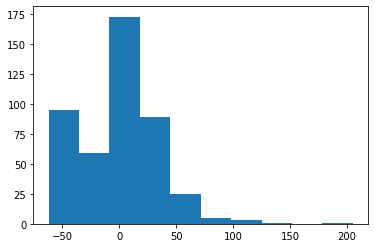

In [320]:
print(f'average profit of a negative trade: {copy_df[(copy_df.profit < 0) & (copy_df.profit > -400)].profit.mean():.2f}')
plt.hist(copy_df[(copy_df.profit > -1000)].profit.values)

In [321]:
copy_df[copy_df.profit < 0].groupby(by='typeHolding').describe()

position                                                 \
                      count       mean         std         min         25%   
typeHolding                                                                  
endPeriod              76.0  -9.514404  182.510175 -185.354129 -182.150532   
fatExtraProfit          2.0   0.613863  257.173360 -181.235165  -90.310651   
lightCross             19.0  -9.830625  186.731345 -183.912735 -182.496614   
lightCrossEmergent      4.0   0.446540  207.373043 -181.520113 -177.924419   
stopLoss               83.0  28.650461  180.436210 -186.122740 -180.862564   

                                                       openPrice              \
                           50%         75%         max     count        mean   
typeHolding                                                                    
endPeriod          -175.763389  182.144680  185.454932      76.0  110.189175   
fatExtraProfit        0.613863   91.538376  182.462890       2.0  109.982595   
lightCross         -179.153594  182.103249  183.682389      19.0  109.889735   
lightCrossEmergent    0.128990  178.499949  183.048295       4.0  111.403929   
stopLoss            178.737924  182.660748  186.374770      83.0  110.166944   

                    ... closeIndex           profit                           \
                    ...        75%       max  count       mean           std   
typeHolding         ...                                                        
endPeriod           ...  300985.50  399630.0   76.0 -18.956288  1.339964e+01   
fatExtraProfit      ...  242349.25  268202.0    2.0  -3.354249  2.599876e+00   
lightCross          ...  303755.00  392793.0   19.0 -16.420701  9.681656e+00   
lightCrossEmergent  ...  148898.75  228359.0    4.0  -5.222942  2.687931e+00   
stopLoss            ...  300260.00  401978.0   83.0 -62.000000  1.306729e-12   

                                                                           
                          min        25%        50%        75%        max  
typeHolding                                                                
endPeriod          -49.612678 -27.187045 -16.807163  -7.886094  -0.580029  
fatExtraProfit      -5.192639  -4.273444  -3.354249  -2.435054  -1.515860  
lightCross         -38.178029 -21.743216 -17.102414 -10.355102  -0.189519  
lightCrossEmergent  -8.205376  -6.834687  -5.366855  -3.755110  -1.952682  
stopLoss           -62.000000 -62.000000 -62.000000 -62.000000 -62.000000  

[5 rows x 64 columns]

In [322]:
copy_df.groupby(by='typeHolding').describe()

position                                                 \
                      count       mean         std         min         25%   
typeHolding                                                                  
endPeriod             166.0  -6.148507  182.041885 -185.354129 -181.761969   
fatExtraProfit         54.0 -40.041130  178.941019 -185.277424 -182.367038   
lightCross             35.0  -5.485139  184.895764 -184.160753 -182.546503   
lightCrossEmergent    113.0  -1.584539  182.861174 -186.351155 -182.429620   
stopLoss               83.0  28.650461  180.436210 -186.122740 -180.862564   

                                                       openPrice              \
                           50%         75%         max     count        mean   
typeHolding                                                                    
endPeriod          -175.627729  182.587817  186.968384     166.0  110.170303   
fatExtraProfit     -179.459494  182.140402  186.684023      54.0  110.071316   
lightCross         -179.153594  182.298705  184.237698      35.0  109.710836   
lightCrossEmergent -175.698868  182.461692  185.467352     113.0  109.882341   
stopLoss            178.737924  182.660748  186.374770      83.0  110.166944   

                    ... closeIndex           profit                           \
                    ...        75%       max  count       mean           std   
typeHolding         ...                                                        
endPeriod           ...  310609.50  403621.0  166.0  11.439293  3.843252e+01   
fatExtraProfit      ...  268739.75  395912.0   54.0  16.181785  8.696446e+00   
lightCross          ...  285163.00  392793.0   35.0  -1.837868  1.905732e+01   
lightCrossEmergent  ...  301379.00  397524.0  113.0  16.595147  1.191793e+01   
stopLoss            ...  300260.00  401978.0   83.0 -62.000000  1.306729e-12   

                                                                            
                          min        25%        50%        75%         max  
typeHolding                                                                 
endPeriod          -49.612678 -14.860923   3.725316  29.941924  205.078458  
fatExtraProfit      -5.192639  10.786455  15.336458  20.414789   46.352387  
lightCross         -38.178029 -17.243775  -1.815371  11.866667   35.832576  
lightCrossEmergent  -8.205376  10.189683  13.633567  21.328587   63.733377  
stopLoss           -62.000000 -62.000000 -62.000000 -62.000000  -62.000000  

[5 rows x 64 columns]

In [323]:
copy_df.profit.cumsum().iloc[-1]

-562.3348034236566

In [ ]:
plt.figure(figsize=(14,8))
plt.style.use('Solarize_Light2')
plt.plot(copy_df.profit.cumsum())
plt.title(f'Total Pnl for {pairName}')
plt.show()